# Undestanding the opioid crisis with a modified epidemic model
----

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import time
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import data

In [2]:
data = pd.read_csv('NCHS_-_Drug_Poisoning_Mortality_by_State__United_States (1).csv')
data.columns = [u'Year', u'Sex', u'Age', u'Race', u'State', 
                u'Deaths', u'Population', u'Crude Death Rate', 
                u'Standard Error for Crude Rate', u'Low Confidence Limit for Crude Rate', 
                u'Upper Confidence Limit for Crude Rate', u'Age-adjusted Rate', 
                u'Standard Error Age-adjusted Rate', 
                u'Lower Confidence Limit for Age-adjusted rate', 
                u'Upper Confidence Limit for Age-adjusted Rate', 
                u'State Crude Rate in Range', u'US Crude Rate', 
                u'US Age-adjusted Rate']

data = data.query('Age== "All Ages" & Sex=="Both Sexes" & Race=="All Races-All Origins" & State!="United States"')

data['Deaths'] = data['Deaths'].apply(lambda x: x.replace(',',''))
data['Deaths'] = pd.to_numeric(data['Deaths'], errors='coerce')
data['Population'] = data['Population'].apply(lambda x: x.replace(',',''))
data['Population'] = pd.to_numeric(data['Population'], errors='coerce')
data['Age-adjusted Rate'] = data['Age-adjusted Rate']*data['Population']/100000

In [345]:
# Load and join opioid timeseries

opioids_kenan = pd.read_csv("data/opioid_prescriptions_kenan_et_al.csv")

opioids_cdc = pd.read_csv("data/opioid_prescriptions_cdc.csv")
opioids_cdc.columns = ["year", "prescriptions", "prescription_rate_per_100"]
opioids_cdc = opioids_cdc[["year", "prescription_rate_per_100"]]

opioids = pd.concat([
    opioids_kenan[opioids_kenan.year < 2006],
    opioids_cdc]).set_index("year")

# merge with pop data
pop = pd.read_csv("data/census_yearly_population.csv").set_index("year") * 1000

df = opioids.join(pop, how="left")
df["prescriptions"] = (df.population / 100) * df.prescription_rate_per_100

df["prescribed_population"] = df.prescriptions / 3.6
df["prescribed_population_percent"] = (df.prescriptions / 3.6) / df.population

# Merge with deaths
df = df.join(yearly_deaths).rename(columns={"Deaths": "deaths"})
df["opioid_death_rate"] = df.deaths / df.population

df = df.reset_index()[df.reset_index().year != 2016]

df.year = df.year.astype(int)

df.deaths = df.deaths.astype(int)

#print(df[["year", "population", "prescribed_population", "deaths"]].to_latex())
df[["year", "population", "prescribed_population", "deaths"]].to_csv("merged_data.csv", index=False)

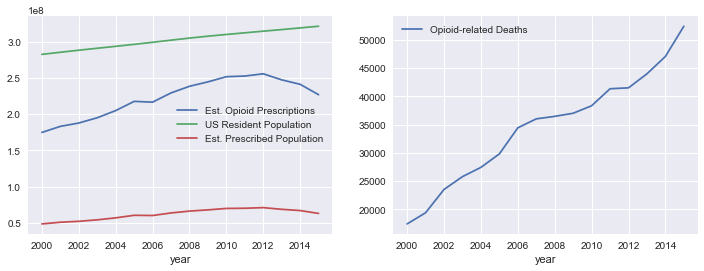

In [294]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

df.plot("year", "prescriptions", ax=ax[0], label="Est. Opioid Prescriptions")
df.plot("year", "population", ax=ax[0], label="US Resident Population")
df.plot("year", "prescribed_population", ax=ax[0], label="Est. Prescribed Population")
df.plot("year", "deaths", ax=ax[1], label="Opioid-related Deaths")

In [410]:
SPAR0 = [0.81, 0.17, 0.0045, 0.0155]

In [411]:
def opioid_ours(state, t, alpha, beta_1, beta_2, gamma, zeta, delta, sigma, epsilon):
    S, P, A, R = state
    nu = (1 - sigma - delta - mu)/A
    S_prime = -alpha*S - beta_1*S*A - beta_2*S*P + epsilon*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (1 + mu)*P
    A_prime = gamma*P + sigma*R + beta_1*S*A + beta_2*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    return [S_prime, P_prime, A_prime, R_prime]

In [412]:
def integrated_model(params):
    
    state0 = SPAR0
    t = np.linspace(0, 16, 16)
    
    alpha, beta_1, beta_2, gamma, zeta, delta, sigma, epsilon = params
    
    numerical_sol = sp.integrate.odeint(opioid_ours, state0, t,
                                        args=(alpha, beta_1, beta_2, gamma, zeta, delta, sigma, epsilon))

    opioid_deaths = numerical_sol[:,2] * (mu_star - mu)
    P = numerical_sol[:,1]
    
    # calculate error
    abs_errors = np.abs(actual - np.vstack([opioid_deaths, P]).T)
    
    # Weight the values to put them on the same scale
    abs_errors[:, 0] = abs_errors[:, 0] * 100
    
    return np.sum(abs_errors)

In [419]:
# parameters
epsilon = 0.74 # Prescribed to Susceptible rate
gamma = 0.26 # rate of addiction among prescribed users
gamma = 0.08
sigma = 0.7 # natural relapse rate of R 
mu = 0.00824 # death rate
mu_star = 0.023 #0.0235275 what I think it should be
delta = 0.6 # R to S rate. 0.1 is default
beta_1 = 0.0625 # total addiction rate for Susceptible due to illegal access
beta_2 = 0.0625 # total addiction rate for Susceptible due to illegal access
alpha = 0.3 # prescription rate. could be 0-1
zeta = 0.7 # rate of A entry into rehab. could be 0-1

# real world data
actual = df[["opioid_death_rate", "prescribed_population_percent"]].values


# Try first with actual parameters
ret = sp.optimize.minimize(integrated_model,
                     (alpha, beta_1, beta_2, gamma, zeta, delta, sigma, epsilon),
                     bounds=[(0,1), (0, 1), (0, 1), (0,1), (0, 1), (0,1), (0,1), (0, 1)],
                     method="TNC",
                     options={"maxiter": 2000}
                     )


best_fit = ret

# Do multistarts
for i in range(100):

    params0 = np.random.rand(8)

    ret = sp.optimize.minimize(integrated_model,
                     params0,
                     bounds=[(0,1), (0, 1), (0, 1), (0,1), (0, 1), (0,1), (0,1), (0, 1)],
                     method="TNC",
                     options={"maxiter": 2000}
                     )
    
    if ret.fun < best_fit.fun:
        best_fit = ret

In [420]:
best_fit

     fun: 0.16811466973776207
     jac: array([ -6.95855540e-02,   1.71178072e-03,   1.06097059e-01,
        -6.31736774e-01,  -1.67323655e-03,  -1.30570221e-02,
        -2.22044605e-08,  -6.93717417e-01])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 277
     nit: 31
  status: 1
 success: True
       x: array([  2.50124499e-01,   0.00000000e+00,   2.48079126e-07,
         4.07294319e-02,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00])

In [421]:
alpha, beta_1, beta_2, gamma, zeta, delta, sigma, epsilon = ret.x

numerical_sol = sp.integrate.odeint(opioid_ours, SPAR0, t,
                                    args=(alpha, beta_1, beta_2, gamma, zeta, delta, sigma, epsilon)
                                   )

S = numerical_sol[:,0]
P = numerical_sol[:,1]
A = numerical_sol[:,2]
R = numerical_sol[:,3]

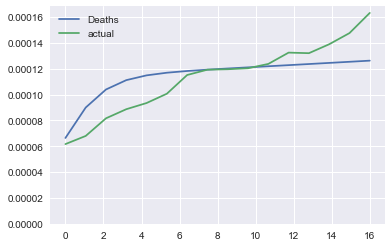

In [422]:
plt.plot(t, (mu_star-mu)*A, label="Deaths")
plt.plot(t, df.opioid_death_rate, label = "actual")
plt.ylim(ymin=0)
plt.legend()

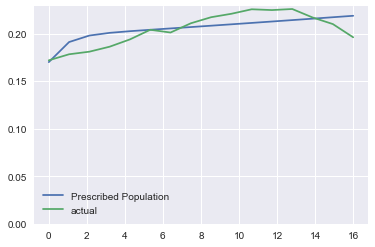

In [423]:
plt.plot(t, P, label="Prescribed Population")
plt.plot(t, df.prescribed_population_percent, label = "actual")
plt.ylim(ymin=0)
plt.legend()

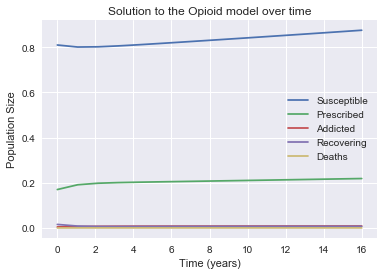

In [428]:
plt.plot(t, S, label="Susceptible")
plt.plot(t, P, label= "Prescribed")
plt.plot(t, A, label= "Addicted")
plt.plot(t, R, label= "Recovering")
plt.plot(t, (mu_star-mu)*A, label="Deaths")
plt.title("Solution to the Opioid model over time")
plt.xlabel("Time (years)")
plt.ylabel("Population Size")
plt.legend()